In [1]:
!pip install np_utils

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install spectral

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install keras
!pip install tensorflow
!pip install jupyter-tensorboard
!pip install scikit-learn
!pip install plotly
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [4]:
#os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

from array import array

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral
import math
import pickle
import tensorboard

init_notebook_mode(connected=True)
%matplotlib inline

# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)
# !rm -r sample_data


2024-05-22 16:11:33.791594: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-22 16:11:33.941958: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 16:11:34.739218: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
# if not (os.path.isfile('Indian_pines_corrected.mat')):
#   !wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
# if not (os.path.isfile('Indian_pines_gt.mat')):
#   !wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat

#if not (os.path.isfile('/content/Salinas_corrected.mat')):
#  !wget https://github.com/gokriznastic/HybridSN/raw/master/data/Salinas_corrected.mat
#if not (os.path.isfile('/content/Salinas_gt.mat')):
#  !wget https://github.com/gokriznastic/HybridSN/raw/master/data/Salinas_gt.mat

# Data Loading

In [6]:
## GLOBAL VARIABLES
dataset = 'IP'
#test_ratio = 0.7

windowSize = 25

In [7]:
def loadData(name):
    data_path = '../Indian Pines/'

    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']

    return data, labels


In [8]:
from sklearn.model_selection import train_test_split
testRatio=0.1
validationRatio=0.1
def splitTrainTestValidationSet(X, y, testRatio, validationRatio, randomState=345):
    # Calculate the proportion of the validation set out of the total dataset
    validation_size = validationRatio / (1 - testRatio)
    
    # Split the dataset into a temporary training set and a testing + validation set
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(testRatio + validationRatio), random_state=randomState,
                                                      stratify=y)
    
    # Split the temporary dataset into the actual testing set and the validation set
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=validation_size, random_state=randomState,
                                                      stratify=y_temp)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [9]:
#def splitTrainTestSet(X, y, testRatio, randomState=345):
#    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
#                                                        stratify=y)
#    return X_train, X_test, y_train, y_test

In [10]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [11]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [12]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [13]:
X, y = loadData(dataset)

X.shape, y.shape

((145, 145, 200), (145, 145))

In [14]:
K = X.shape[2]

In [15]:
K = 30 if dataset == 'IP' else 15
X,pca = applyPCA(X,numComponents=K)

X.shape

(145, 145, 30)

In [16]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((10249, 25, 25, 30), (10249,))

In [17]:
Xtrain, Xval, Xtest, ytrain, yval, ytest = splitTrainTestValidationSet(X, y, testRatio,validationRatio)

Xtrain.shape, Xval.shape, Xtest.shape, ytrain.shape, yval.shape, ytest.shape

((8199, 25, 25, 30),
 (1822, 25, 25, 30),
 (228, 25, 25, 30),
 (8199,),
 (1822,),
 (228,))

Xtrain, Xvalid, ytrain, yvalid = splitTrainTestSet(Xtrain, ytrain, 0.3333)

Xtrain.shape, Xvalid.shape, ytrain.shape, yvalid.shape

# Model and Training

In [18]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xval = Xval.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape, Xval.shape

((8199, 25, 25, 30, 1), (1822, 25, 25, 30, 1))

In [19]:
ytrain = keras.utils.to_categorical(ytrain)
yval = keras.utils.to_categorical(yval)

ytrain.shape, yval.shape

((8199, 16), (1822, 16))

Xvalid = Xvalid.reshape(-1, windowSize, windowSize, K, 1)
Xvalid.shape

yvalid = np_utils.to_categorical(yvalid)
yvalid.shape

In [20]:
S = windowSize
L = K
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

In [21]:
## input layer
input_layer = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
#print(conv_layer3._keras_shape)
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

2024-05-22 16:11:43.237297: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [22]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [23]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 25, 25, 30, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 23, 23, 24, 8)  │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 21, 21, 20, 16) │         5,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 19, 19, 18, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 19, 19, 576)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 17, 17, 64)     │       331,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,735,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,122,176 (19.54 MB)

 Trainable params: 5,122,176 (19.54 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.00001,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [25]:
# compiling the model
adam = Adam(learning_rate=0.00001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:34: UserWarning:

Argument `decay` is no longer supported and will be ignored.



In [26]:
import datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


def step_decay(epoch):
   initial_lrate = 0.00001
   drop = 0.10
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate

class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
       self.losses = []
       self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
       self.losses.append(logs.get('loss'))
       self.lr.append(step_decay(len(self.losses)))
loss_history=LossHistory()

In [27]:
# checkpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

filepath = "best-model-150e-IP.keras"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
callbacks_list = [checkpoint,early_stopping]

In [32]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=150, callbacks=callbacks_list, validation_data=(Xval,yval))

Epoch 1/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 560ms/step - accuracy: 0.9956 - loss: 0.0192 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 2/150


/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning:

Can save best model only with acc available, skipping.



33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 498ms/step - accuracy: 0.9948 - loss: 0.0184 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 3/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 512ms/step - accuracy: 0.9936 - loss: 0.0199 - val_accuracy: 0.9989 - val_loss: 0.0026
Epoch 4/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 509ms/step - accuracy: 0.9946 - loss: 0.0211 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 5/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 510ms/step - accuracy: 0.9930 - loss: 0.0202 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 6/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 514ms/step - accuracy: 0.9942 - loss: 0.0223 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 7/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 511ms/step - accuracy: 0.9964 - loss: 0.0146 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 8/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 495ms/step - accuracy: 0.9942 - loss: 0.0196 - val_accuracy: 1.0000 - val_loss: 9.9300e-04
Epoch 9/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 502ms/step - accuracy: 0.9958 - loss: 0.0173 - val_accu

In [ ]:
model.save("best-model-150e-IP.keras")

In [ ]:
def show_final_history(history):
    
    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    
    ax[0].plot(history.history['loss'], 'r-', label='Training Loss')
    ax[0].plot(history.history['val_loss'], 'g-', label='Validation Loss')
    ax[1].plot(history.history['accuracy'], 'r-', label='Training Accuracy')
    ax[1].plot(history.history['val_accuracy'], 'g-', label='Validation Accuracy')
    
    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')
    
    plt.show();
    pass

In [ ]:
show_final_history(history)

# Validation

In [32]:
# load best weights
model.load_weights("best-model-150e-IP.keras")
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [33]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(1206, 25, 25, 30, 1)

In [34]:
ytest = keras.utils.to_categorical(ytest)
ytest.shape

(1206, 16)

In [35]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.99      0.99       168
           2       1.00      1.00      1.00        98
           3       1.00      1.00      1.00        28
           4       1.00      1.00      1.00        57
           5       1.00      1.00      1.00        86
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00        56
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00       114
          10       0.99      1.00      1.00       289
          11       1.00      1.00      1.00        70
          12       1.00      1.00      1.00        24
          13       1.00      1.00      1.00       149
          14       1.00      1.00      1.00        46
          15       1.00      1.00      1.00        11

    accuracy                           1

In [50]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [51]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed',
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']

    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100

    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [52]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report-IP.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [36]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]

    return patch

In [37]:
# load the original image
X, y = loadData(dataset)

In [38]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [39]:
X,pca = applyPCA(X, numComponents=numComponents)

In [40]:
X = padWithZeros(X, PATCH_SIZE//2)

In [48]:
# # calculate the predicted image
# outputs = np.zeros((height,width))
# for i in range(height):
#     for j in range(width):
#         target = int(y[i,j])
#         if target == 0 :
#             continue
#         else :
#             image_patch=Patch(X,i,j)
#             X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')
#             prediction = (model.predict(X_test_image))
#             prediction = np.argmax(prediction, axis=1)
#             outputs[i][j] = prediction+1

In [44]:
original_X, original_Y=loadData(dataset)

In [45]:
original_X.shape

(145, 145, 200)

In [46]:
import sys
import os
import numpy as np

# Redirect stdout to /dev/null to suppress the output
sys.stdout = open(os.devnull, 'w')

# calculate the predicted image
outputs = np.zeros((height, width))
pure_pixels = {}

for i in range(height):
    for j in range(width):
        target = int(y[i, j])
        if target == 0:
            continue
        else:
            image_patch = Patch(X, i, j)
            X_test_img = image_patch.reshape(1, image_patch.shape[0], image_patch.shape[1], image_patch.shape[2], 1).astype('float32')
            
            # Predictions
            prediction = model.predict(X_test_img)[0]
            predicted_class = np.argmax(prediction)
            outputs[i][j] = predicted_class + 1

            # If the pixel is classified as a valid class
            if predicted_class >= 0:
                # Get the probability of the current pixel belonging to its predicted class
                prediction_probability = prediction[predicted_class]
                
                # If the class is not already in the dictionary or the probability is higher than the existing one
                if predicted_class not in pure_pixels or prediction_probability > pure_pixels[predicted_class]['probability']:
                    # Update the dictionary with the new pure pixel information
                    pure_pixels[predicted_class] = {'probability': prediction_probability, 'coordinates': (i, j)}

# Reset stdout back to normal
sys.stdout = sys.__stdout__

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9957 - loss: 0.0106  


/home/ubuntu/.local/lib/python3.10/site-packages/spectral/graphics/spypylab.py:796: UserWarning:

Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.



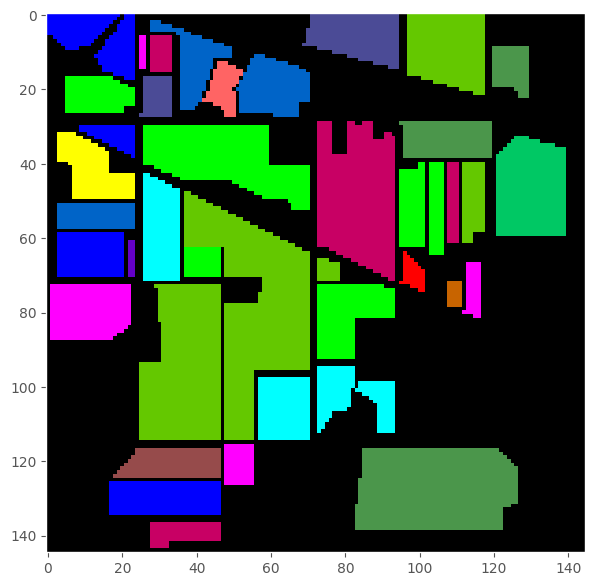

In [47]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

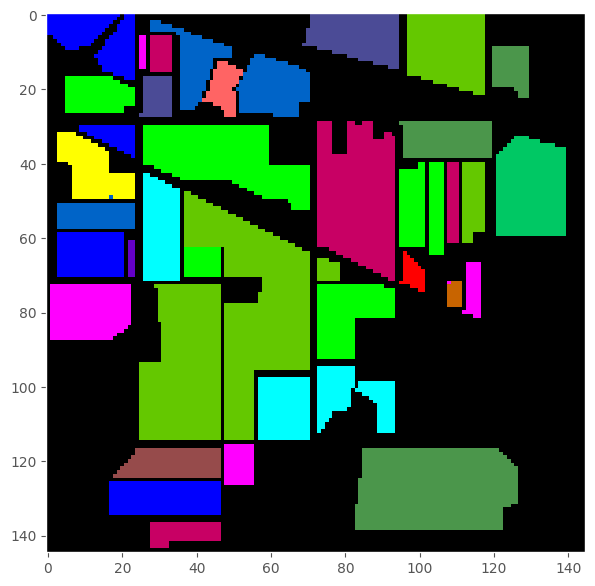

In [48]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))


In [52]:
spectral.save_rgb("predictionsIP.jpg", outputs.astype(int), colors=spectral.spy_colors)

<Figure size 640x480 with 0 Axes>

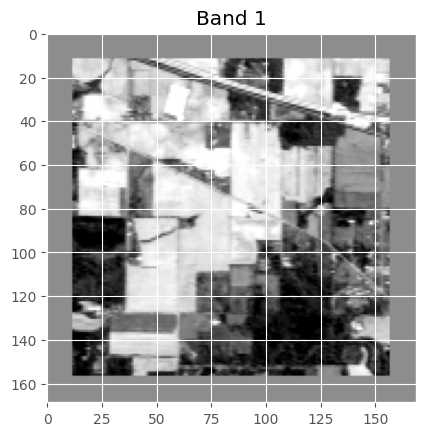

<Figure size 640x480 with 0 Axes>

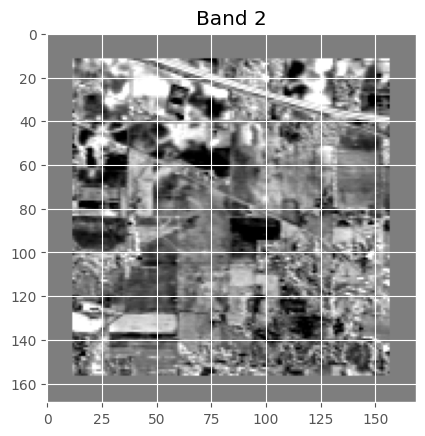

<Figure size 640x480 with 0 Axes>

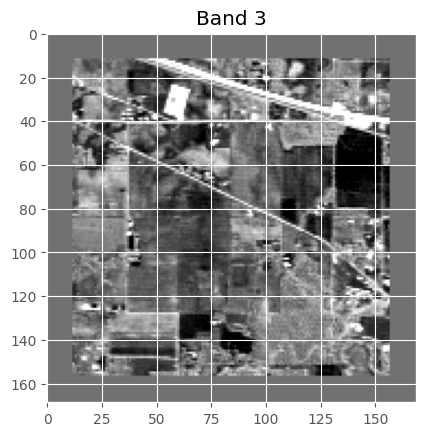

<Figure size 640x480 with 0 Axes>

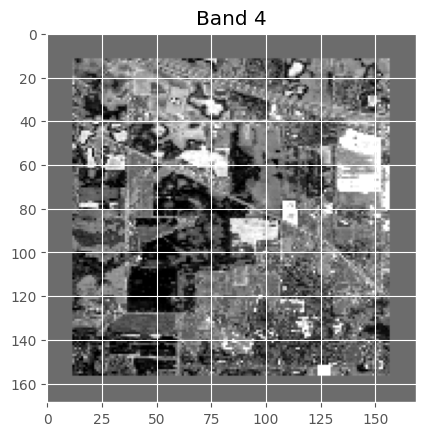

<Figure size 640x480 with 0 Axes>

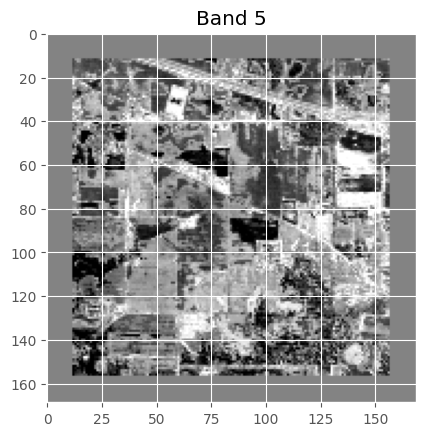

<Figure size 640x480 with 0 Axes>

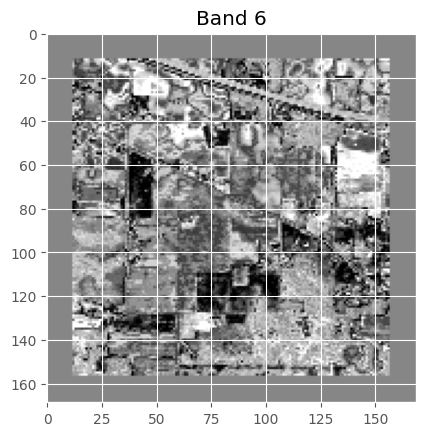

<Figure size 640x480 with 0 Axes>

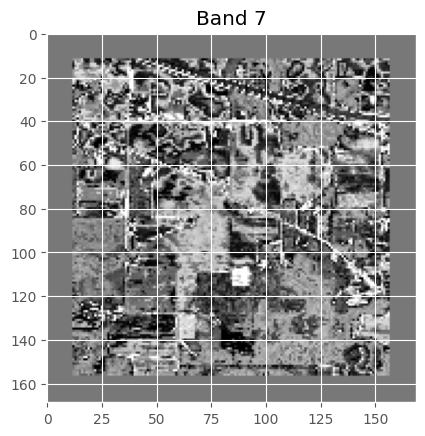

<Figure size 640x480 with 0 Axes>

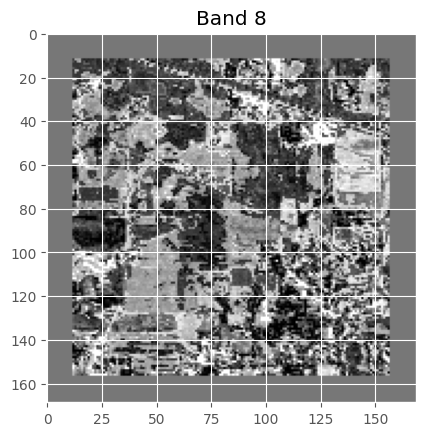

<Figure size 640x480 with 0 Axes>

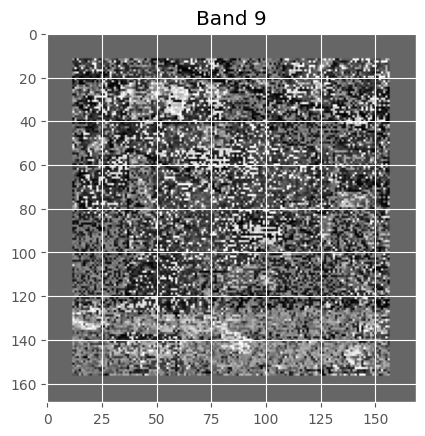

<Figure size 640x480 with 0 Axes>

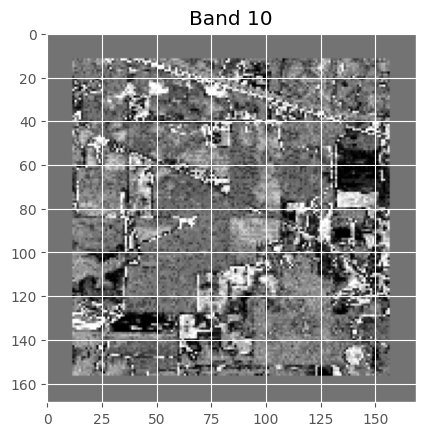

<Figure size 640x480 with 0 Axes>

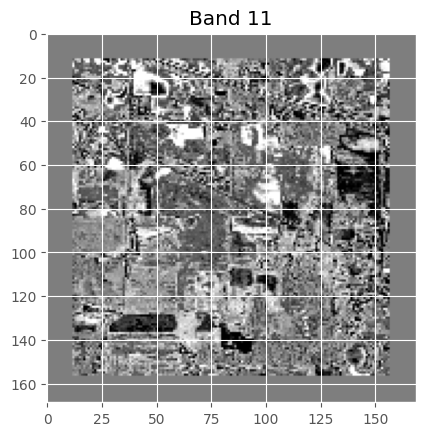

<Figure size 640x480 with 0 Axes>

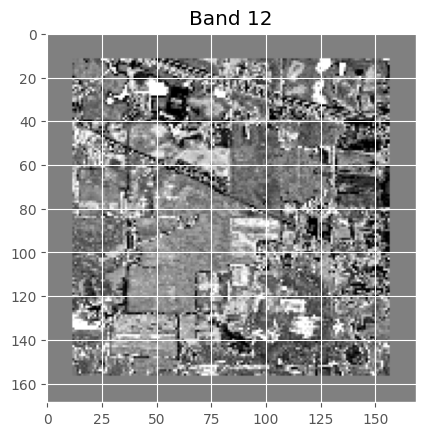

<Figure size 640x480 with 0 Axes>

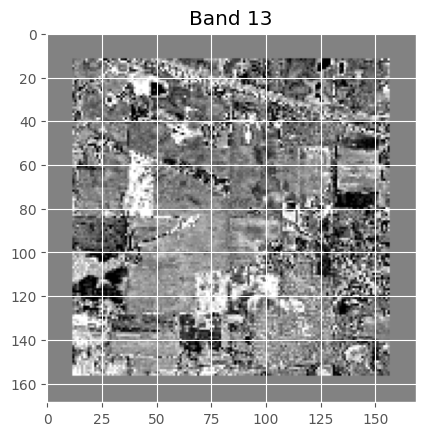

<Figure size 640x480 with 0 Axes>

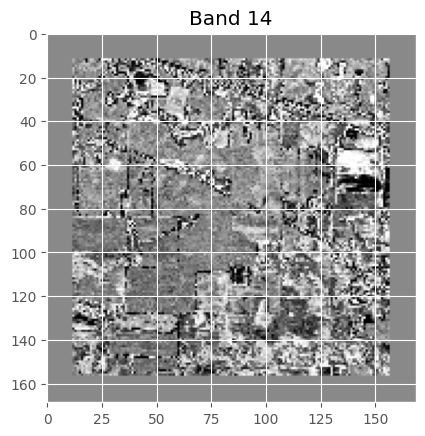

<Figure size 640x480 with 0 Axes>

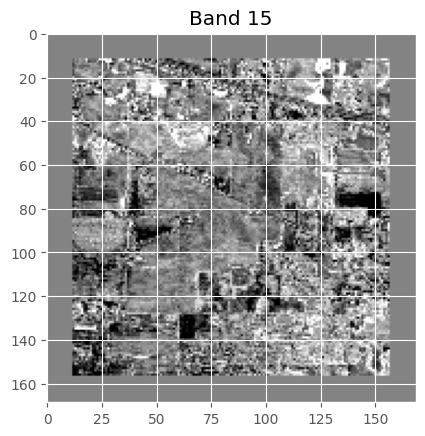

<Figure size 640x480 with 0 Axes>

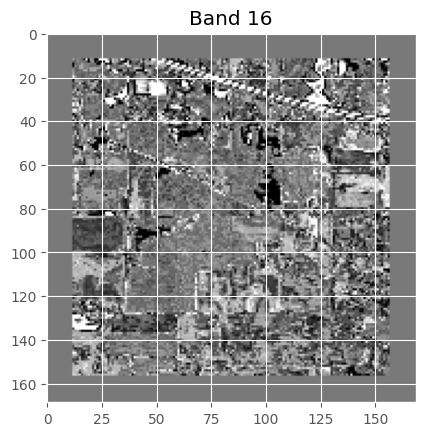

<Figure size 640x480 with 0 Axes>

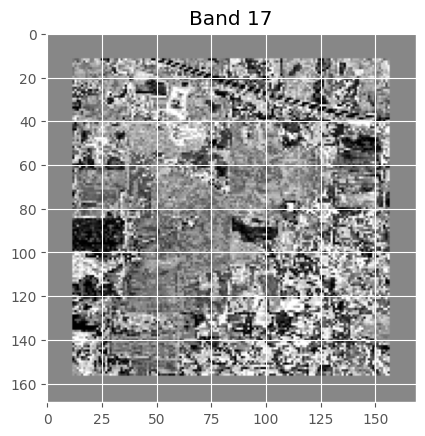

<Figure size 640x480 with 0 Axes>

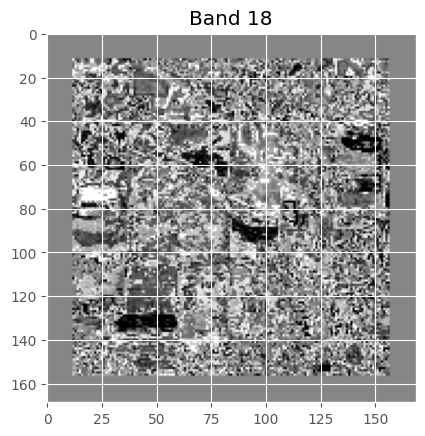

<Figure size 640x480 with 0 Axes>

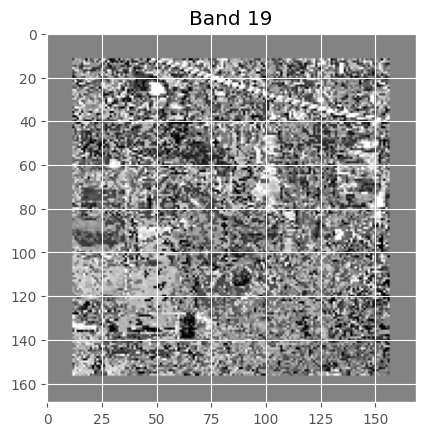

<Figure size 640x480 with 0 Axes>

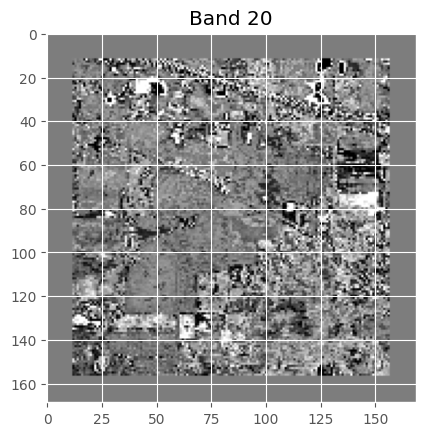

<Figure size 640x480 with 0 Axes>

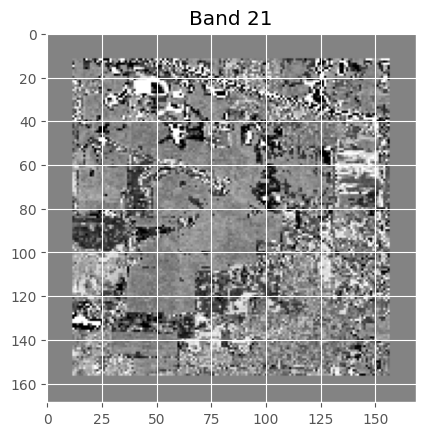

<Figure size 640x480 with 0 Axes>

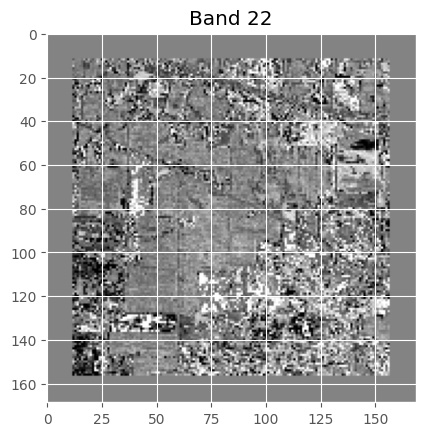

<Figure size 640x480 with 0 Axes>

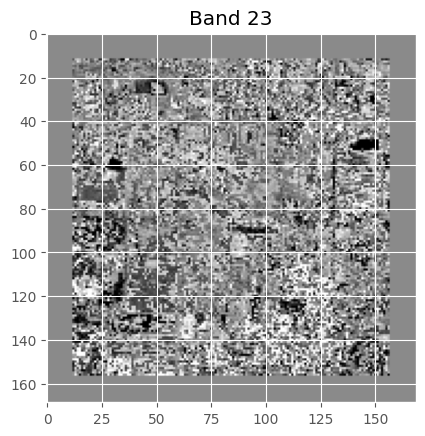

<Figure size 640x480 with 0 Axes>

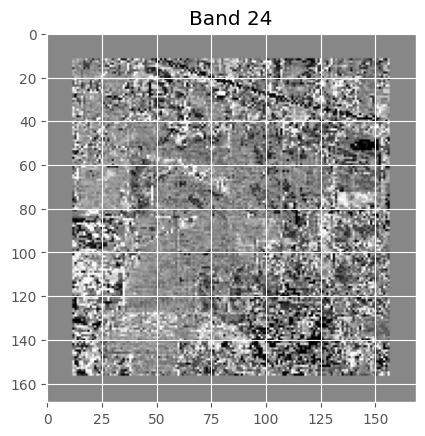

<Figure size 640x480 with 0 Axes>

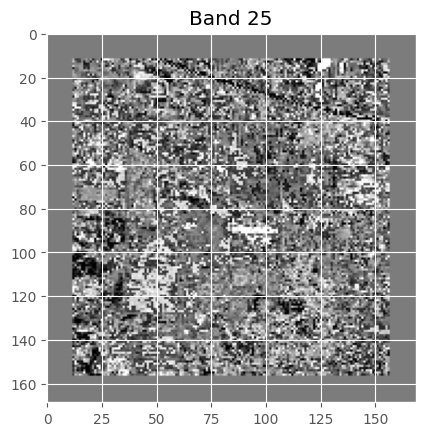

<Figure size 640x480 with 0 Axes>

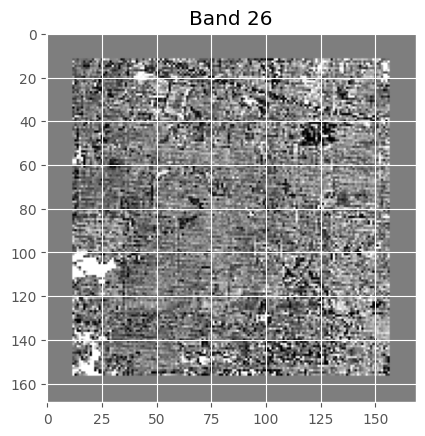

<Figure size 640x480 with 0 Axes>

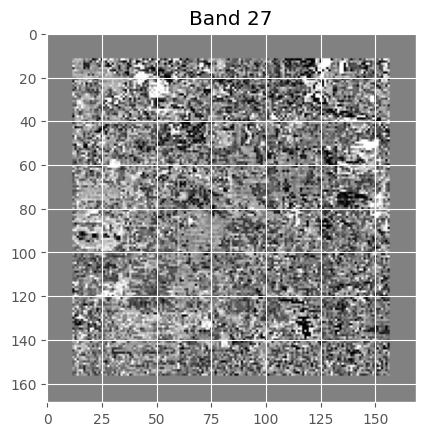

<Figure size 640x480 with 0 Axes>

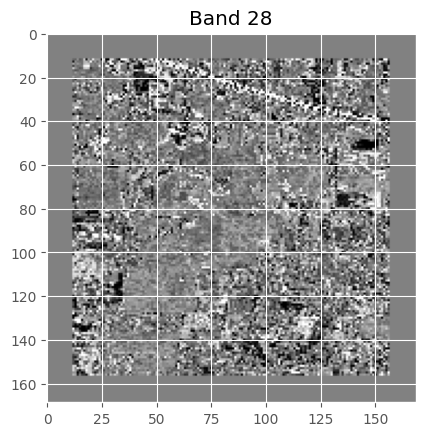

<Figure size 640x480 with 0 Axes>

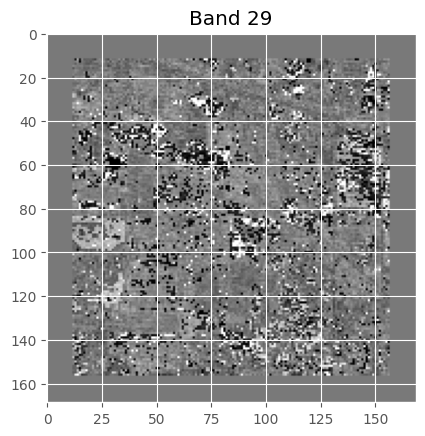

<Figure size 640x480 with 0 Axes>

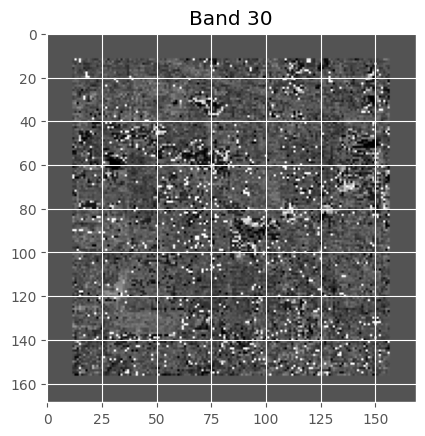

In [49]:
import spectral
import matplotlib.pyplot as plt


# Assuming your image has a shape of (610, 340, 15)
image_shape = X.shape

# Loop through each band and display it
for band_index in range(image_shape[2]):
    # Extract the band
    band = X[:,:,band_index]

    # Display the band
    plt.figure()
    spectral.imshow(band, stretch=(0.02, 0.98), title=f"Band {band_index+1}")
    plt.show()


# Pure Pixels

spectral.save_rgb(str(dataset)+"_ground_truth.jpg", y, colors=spectral.spy_colors)